# Better priors represented as particles

## Setup 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# gpflow doesn't come preloaded with colab.
!pip3 install gpflow

In [3]:
import numpy as np
import time

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib
import matplotlib.pyplot as plt

from gdrive.MyDrive.prior_learning.spectral_stein_grad.estimator import SpectralScoreEstimator
from gdrive.MyDrive.prior_learning import data_utils
from gdrive.MyDrive.prior_learning import prior_utils
from gdrive.MyDrive.prior_learning import sliced_score_estimation

tf.compat.v1.enable_eager_execution()


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
tf.executing_eagerly()

True

In [5]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Building the dataset

In [6]:
tasks_data = data_utils.GetSinusoidParams(task_count=10)

In [7]:
config = {
          'input_shape': 1,             # Shape of input data.
          'size': 5,                    # Number of samples.  
          'generation_method': 'sine',  # Generating process of the labels.
          'tasks_data': tasks_data,     # Hyperparams for the sinusoids.
}

In [8]:
X, y = data_utils.GetDataset(config)
X = X[:, None]
test_tasks_cnt = 1

first_test_idx = len(X) - test_tasks_cnt * config['size']
X_train, y_train = X[:first_test_idx], y[:first_test_idx]
X_test, y_test = X[first_test_idx:], y[first_test_idx:]

In [9]:
X_train.shape, X_test.shape

((45, 1), (5, 1))

In [10]:
scaler = StandardScaler().fit(X_train)

In [11]:
# Use the same scaler in order to ensure that we don't inject knowledge
# about the test distribution in our training biases.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

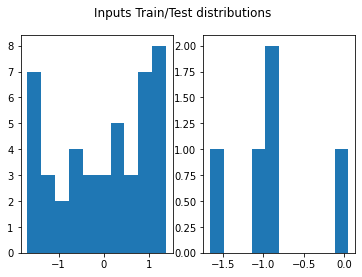

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Inputs Train/Test distributions')
ax1.hist(X_train, bins=10)
ax2.hist(X_test, bins=10)
plt.show()

In [13]:
# Scale both dataset by `y_train_max`. Same reasoning
# as in using the same scaler on inputs. This is done to avoid
# exploding gradients.
y_train_max = y_train.max()
y_train /= y_train_max
y_test /= y_train_max

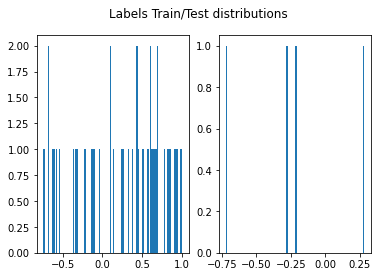

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Labels Train/Test distributions')
ax1.hist(y_train, bins=100)
ax2.hist(y_test, bins=100)
plt.show()

## GP Prior Setup

Train a $\mathcal{GP}$ on the training data, so that we may later use the tuned kernel for estimating the covariance of a Normal distribution over function values (this shall be used as the prior in the `f-bnn` formulation below).

In [15]:
# Pre-train GP prior.
gp_prior, _ = prior_utils.TrainGPPrior(X_train, y_train)

## Sliced Score Estimator Setup (https://arxiv.org/pdf/1905.07088.pdf)

Here we train a network $h(\cdot, \hat{\theta})$ which minimizes the objective $\mathbb{E}_{x \sim \mu} \Vert h(x, \hat{\theta}) - \nabla_x \log p(x) \Vert_{2}$ in an unsupervised way, where $\mu$ is some unknown data generating process and $p := \sum_i \delta_{x_i}$ is an empirical measure represented as a set of particles.

In [16]:
input_shape = (1,)
score_net = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape, name='input'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(input_shape[0]),
])

config_slice_train = {'data': y_train[:, None],
          'score_net': score_net,
          'epochs': 100, 
          'lambda_reg': 0.15
}

In [17]:
score_net, best_loss = (
    sliced_score_estimation.GetSlicedScoreEstimator(config_slice_train,
                                                    verbose=True))

Epoch [0], loss: [23.709580]
Epoch [10], loss: [15.060834]
Epoch [20], loss: [21.777864]
Epoch [30], loss: [9.547924]
Epoch [40], loss: [6.202498]
Epoch [50], loss: [12.899797]
Epoch [60], loss: [13.554813]
Epoch [70], loss: [-2.276959]
Epoch [80], loss: [5.535917]
Epoch [90], loss: [3.880795]


## Model setup

In [18]:
def ApproximateEntropyGrads(estimator, samples):
  dlog_q = estimator.compute_gradients(samples)
  surrogate = tf.reduce_mean(
      tf.reduce_sum(
          tf.stop_gradient(-dlog_q) * tf.cast(samples, tf.float64), -1))
  return surrogate

In [19]:
def InjectNoise(x, mean=0.0, std=1.0):
  return x + np.random.normal(mean, std, size=x.shape)

In [20]:
# Estimator to be used for computing score gradients of implicit distributions
# represtend as sets of particles.
estimator = SpectralScoreEstimator(n_eigen_threshold=0.99, eta=0.0)

In [21]:
# TODO: Allow for customizable models.
def _GetModel():
  kl_divergence_function = (lambda q, p, _:
                            tfp.distributions.kl_divergence(q, p) /
                            tf.cast(len(X_train), dtype=tf.float32))

  # Setup a feed forward BNN with 1 hidden layer.
  model = tf.keras.Sequential([
      tf.keras.Input(shape=X_train[0].shape,name='input'),
      tfp.layers.DenseFlipout(10, kernel_divergence_fn=kl_divergence_function,
                              activation=tf.nn.relu, name="dense_tfp_1"),
      tfp.layers.DenseFlipout(1,
                              kernel_divergence_fn=kl_divergence_function,
                              name="out_tfp_pred"),
  ])

  return model

Reframing variational inference in the function space, we arrive at the following objective formulation [Sun et al., 2019]

\begin{equation}
 \log p(\mathcal{D} \vert f) - \lambda KL(q \Vert p) \hspace{0.5cm}(1)
\end{equation}

where $q, p$ represent the posterior, and the prior over function values.

Using the reparametrization trick, function values $f(x) \sim q(\cdot)$ are drawn from a parameterized neural net $g_\phi(x ; \xi)$. Here $\phi$ denotes the set of optimizable parameters, while $\xi$ is a random perturbation under which the change of variable is performed. Hence, drawing samples $f(x) \sim q$ is done by forwarding $x$ through $g_\phi(\cdot ; \xi)$.

In order to obtain a feasible optimization procedure from $(1)$, the $KL$ divergence is then expanded as 

\begin{equation}
 KL(q \Vert p)  = \mathbb{E}_{\xi}[\nabla_\phi \textbf{f} (\nabla_\textbf{f} \log q(\textbf{f}) - \nabla_\textbf{f}\log p(\textbf{f})  )] \hspace{0.5cm}(2)
\end{equation}

Note that the $KL$ term is made tractable by using SSGE [Shi et al., 2018] to extract gradients for the score functions, since both $q(\cdot), p(\cdot)$ are both implicit distributions represented as particles.

In [22]:
def SamplePosterior(variational_posterior, n_particles, x):
  return np.stack([variational_posterior(x) for _ in range(n_particles)])

In [42]:
model = _GetModel()

epochs = 5
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.001)
n_particles = 10

train_acc_metric = tf.keras.metrics.MeanAbsoluteError()
val_acc_metric = tf.keras.metrics.MeanAbsoluteError()

# The real targets are the true prior.
prior_particles = np.copy(y_train)
if len(prior_particles.shape) == 2:
  prior_particles = np.squeeze(prior_particles, -1)

# If this is disabled the model disregards the KL term and simply optimizes
# the likelihood of the targets.
use_functional_kl = True
lambda_kl = 1.0

# Configs used as arguments for the `ComputeCrossEntropy` function, which
# will be used for computing the log_prior gradients (or approximate gradients).
configs = {
  'gp': {'method': 'gp',  'kernel_function': gp_prior.kernel, 'x': X_train},

  'ssge': {'method': 'ssge', 'estimator': estimator,
           'n_particles': n_particles, 'prior_particles': prior_particles},

  'sliced_score_estimation': {'method': 'sliced', 
                              'score_estimator': score_net},
}

# If 'gp' is chosen here, then the prior will be represented exactly as a GP.
# Otherwise, we will use the ground truth particles as an empirical measure
# and compute approximate gradients with either {SSGE, SSM}.
method = 'sliced_score_estimation'
print('Using %s to represent the prior. \n' % method)

for epoch in range(epochs):
    start_time = time.time()
    with tf.GradientTape() as tape:
        logits = model(X_train, training=True)
        
        # Considering a Gaussian likelihood model, with unit variance.
        neg_log_likelihood = loss_fn(y_train, logits)
        loss_value = neg_log_likelihood 
      
        if use_functional_kl:
          # Use SSGE to approximate the log gradients of the functional
          # posterior given the 'drawn' samples from the neural net.
          # See Equation (2).
          noisy_logits = SamplePosterior(model, n_particles, X_train)
          noisy_logits += np.random.normal(0, 1, size=noisy_logits.shape)
          entropy_sur = ApproximateEntropyGrads(estimator, noisy_logits)
        
          if 'gp' in method:
            configs[method]['y'] = noisy_logits.squeeze(2)
          elif 'ssge' in method:
            configs[method]['y'] = noisy_logits
          elif 'score' in method:
            configs[method]['y'] = noisy_logits.reshape(
                n_particles *  len(y_train), -1)
            
          cross_entropy_sur = prior_utils.ComputeCrossEntropy(configs[method])
          
          # Add these up to produce the KL term to be optimized.
          functional_kl = (tf.cast(entropy_sur, tf.float32) -
                           tf.cast(cross_entropy_sur, tf.float32))
          loss_value += lambda_kl * functional_kl / len(X_train)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y_train, logits)
   
    if epoch % 5 == 0:
    	train_acc = train_acc_metric.result()
    	print("Negative log likelihood over epoch [%d]: %.4f" % 
           (epoch, float(neg_log_likelihood,)))

    train_acc_metric.reset_states()

    # Results on validation dataset.
    val_logits = model(X_test, training=False)
    val_acc_metric.update_state(y_test, val_logits)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation negative log likelihood: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    print()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Using sliced_score_estimation to represent the prior. 

Negative log likelihood over epoch [0]: 0.3657
Validation negative log likelihood: 0.2992
Time taken: 0.22s

Validation negative log likelihood: 0.2923
Time taken: 0.20s

Validation negative log likelihood: 0.2898
Time taken: 0.20s

Validation negative log likelihood: 0.2907
Time taken: 0.19s

Validation negative log likelihood: 0.3038
Time taken: 0.20s



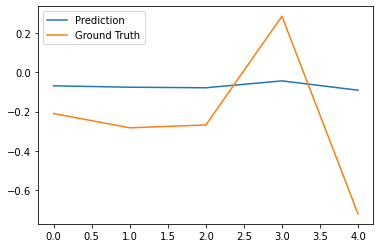

In [43]:
plt.plot(model.predict(X_test))
plt.plot(y_test)

plt.legend(['Prediction', 'Ground Truth'], loc='upper left')
plt.show()